# Тестовое задание Astral AI для аналитика по данным

## Подготавливаемся

In [1]:
import pandas as pd
import numpy as np
import pathlib
from io import StringIO

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from skimage.morphology import skeletonize
from skimage.metrics import adapted_rand_error

from sklearn.metrics import jaccard_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from PIL import Image
import cv2

from itertools import combinations
import warnings
from tqdm.notebook import tqdm

plt.style.use('default')

### Читаем датасет

In [2]:
data_dir = pathlib.Path('Dataset')

In [3]:
# DX_TEST_RESULT_FULL

# Устранение ошибок сохранения csv
# Некоторые строки имеют лишние запятые и пробелы
with open(data_dir.joinpath('DX_TEST_RESULT_FULL.csv'), 'r') as f:
    test_res_df = f.read().replace(', \n', '\n').replace(',\n', '\n').replace(', ', ',')
    
test_res_df = pd.read_csv(StringIO(test_res_df))

# OpenPart.csv
open_part_df = pd.read_csv(data_dir.joinpath('OpenPart.csv'))

### Полезные функции

In [4]:
def check_duplicates(treshold=9):
    """
    Возвращает дубликаты изображений, выявленных с помощью 
    перцептивного хеша по градиенту интенсивности
    """
    
    # Расчет перцептивных хэшей изображений по градиенту интенсивности
    image_hashes = dict()
    for fp in data_dir.joinpath('Origin').iterdir():
        img = cv2.imread(fp.as_posix())
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (8, 8)).astype(np.int8)
        diff = img[:, 1:] - img[:, :-1]
        image_hashes[fp] = diff.flatten()
    
    # поиск дубликатов по заданному порогу
    duplicates = []
    for fn_1, fn_2 in combinations(image_hashes.keys(), r=2):
        if np.equal(image_hashes[fn_1], image_hashes[fn_2]).sum() >= treshold:
            duplicates.append((fn_1, fn_2))
            
    return duplicates


def check_all_images_have_markup():
    """
    Проверяет, у всех ли изображений существует разметка от экспертов и моделей
    """
    
    origin_fnames = {n.name for n in data_dir.joinpath('Origin').glob('*.png')}
    expert_fnames = {n.name.replace('_expert', '') for n in data_dir.joinpath('Expert').glob('*.png')}
    sample_1_fnames = {n.name.replace('_s1', '') for n in data_dir.joinpath('sample_1').glob('*.png')}
    sample_2_fnames = {n.name.replace('_s2', '') for n in data_dir.joinpath('sample_2').glob('*.png')}
    sample_3_fnames = {n.name.replace('_s3', '') for n in data_dir.joinpath('sample_3').glob('*.png')}
    
    if not (origin_fnames == expert_fnames == sample_1_fnames == sample_2_fnames == sample_3_fnames):
        return False

In [5]:
def skeletone_distance(y_true: np.array, y_pred: np.array) -> float:
    """
    Считает метрику Skeletone Distance - среднее расстояние 
    от точек скелета предсказанной маски до ближайших точек 
    скелета ground trueth маски
    
    Об этой метрике было сказано 
    на треке "Ужасы медицинских данных"
    https://youtu.be/-1haCzvDKqg?list=LL&t=626
    
    :param y_true: 
    :param y_pred: 
    """
    
    skel_true = skeletonize(y_true.astype(bool))
    skel_pred = skeletonize(y_pred.astype(bool))

    skel_points_true = np.argwhere(skel_true == 1)
    skel_points_pred = np.argwhere(skel_pred == 1)
    
    if len(skel_points_true) == 0 or len(skel_points_pred) == 0:
        return None
    
    distances = []
    
    for point_pred in skel_points_pred:
        dist = np.sqrt(np.square(skel_points_true - point_pred).sum(axis=1).min())
        distances.append(dist)
    
    return np.mean(distances)


def get_segmentation_metrics(row):
    """
    Рассчитывает метрики сегментации
    """
    img_true = np.array(Image.open(row['expert_mask_fp'])).astype(bool)
    img_pred = np.array(Image.open(row['sample_mask_fp'])).astype(bool)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        dice, prec, rec = adapted_rand_error(img_true, img_pred)

    metrics = {
        'dice': dice,
        'recall': rec,
        'precision': prec,
        'jaccard': jaccard_score(img_true.flatten(),
                                 img_pred.flatten(), zero_division=0),
        'skeletone_dist': skeletone_distance(img_true, img_pred)
    }
    return metrics

In [6]:
def get_mask_fp(origin_fn: str, sub_dir: str, postfix: str):
    """
    Возвращает путь к сегментационной карте
    """
    mask_file_name = origin_fn.replace('.', f'{postfix}.')
    mask_dir = data_dir.joinpath(sub_dir)
    return mask_dir.joinpath(mask_file_name)


def get_segmentation_df():
    """
    Функция для преоразования датасета
    """
    origin_file_names = [fn.name for fn in data_dir.joinpath('Origin').iterdir()]
    origin_file_names = [fn.name for fn in data_dir.joinpath('Origin').iterdir()]
    df = pd.DataFrame(origin_file_names, columns=['origin_fp'])

    # Найдем пути к сегментационным картам, сделанных экспертом и моделями
    df['expert_mask_fp'] = df['origin_fp'].apply(get_mask_fp, sub_dir='Expert', postfix='_expert')
    df['sample_1'] = df['origin_fp'].apply(get_mask_fp, sub_dir='sample_1', postfix='_s1')
    df['sample_2'] = df['origin_fp'].apply(get_mask_fp, sub_dir='sample_2', postfix='_s2')
    df['sample_3'] = df['origin_fp'].apply(get_mask_fp, sub_dir='sample_3', postfix='_s3')

    # "Сплавим" таблицу до формата | origin_fp | expret_mask_fp | sample_id | sample_mask_fp|
    df = df.melt(['origin_fp', 'expert_mask_fp'], var_name='sample_id', value_name='sample_mask_fp')

    # Добавим оценку сегментаций экспертом
    scores_df = open_part_df.melt('Case', var_name='sample_id', value_name='expert_score')
    scores_df['sample_id'] = scores_df['sample_id'].str.replace(' ', '_').str.lower()
    df = df.merge(scores_df, left_on=['origin_fp', 'sample_id'], how='left',
             right_on=['Case', 'sample_id']).drop('Case', axis=1)

    # Посчитаем другие метрики сегментации
    tqdm.pandas(desc='Считаем метрики')
    metrics = df.progress_apply(get_segmentation_metrics, axis=1)
    metrics = pd.DataFrame(metrics.values.tolist())
    df = pd.concat([df, metrics], axis=1)
    
    # Изменим путь к оригиналу для удобства 
    df['origin_fp'] = df['origin_fp'].apply(get_mask_fp, sub_dir='Origin', postfix='')

    return df

In [7]:
def plot_image_segmentation(segmentation_df_row, legend=True, 
                            sample_id=True, image_name=True, metrics=True, ax=None):
    """
    Функция для отображения сегментации для одного изображения одной моделью
    """
    if ax is None:
        ax = plt.gca()
    
    # Читаем картинки
    origin_img =  cv2.imread(segmentation_df_row['origin_fp'].as_posix())
    expert_mask = cv2.imread(segmentation_df_row['expert_mask_fp'].as_posix())
    expert_mask = cv2.cvtColor(expert_mask,cv2.COLOR_BGR2GRAY)
    sample_mask = cv2.imread(segmentation_df_row['sample_mask_fp'].as_posix())
    sample_mask = cv2.cvtColor(sample_mask,cv2.COLOR_BGR2GRAY)
    
    # Рисуем картинку с сегментациями
    expert_contours, _ = cv2.findContours(expert_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    sample_contours, _ = cv2.findContours(sample_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contoured_img = cv2.drawContours(origin_img.copy(), expert_contours, -1, (0, 255, 0), 3)
    contoured_img = cv2.drawContours(contoured_img, sample_contours, -1, (255, 0, 0), 3)
    ax.imshow(contoured_img)
    
    # Рисуем метрики
    if metrics:
        metrics = pd.DataFrame(segmentation_df_row).T
        metrics = metrics.loc[:, ['expert_score', 'dice', 'precision', 'jaccard', 'skeletone_dist']]
        metrics = np.around(metrics.astype(float), 3).rename(
            columns={'expert_score': 'expert', 'skeletone_dist': 'skeletone'})
        metrics = metrics.to_string(index=False, justify='center')
        ax.text(20, 1000, metrics, font='monospace', 
                bbox=dict(facecolor='white', edgecolor='black', 
                          boxstyle='round', alpha=0.9))
    
    if legend:
        green_patch = patches.Patch(color='green', label='Эксперт')
        red_patch = patches.Patch(color='red', label='Модель')
        ax.legend(handles=[green_patch, red_patch])
        
    if sample_id:
        ax.set_title(segmentation_df_row['sample_id'])
    
    if image_name:
        ax.set_xlabel(segmentation_df_row['origin_fp'].name)

    ax.set_xticks([])
    ax.set_yticks([])
    
    
def plot_segmentations(data):
    """
    Функция для отображения сегментации для одного изображения всеми моделями
    """
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flat
    
    data = data.sort_values('sample_id')

    for i in range(3):
        plot_image_segmentation(data.iloc[i], ax=axs[i+1], legend=False)

    # info ax
    axs[0].text(0.5, 0.9, f"Изображение:\n{data['origin_fp'].iloc[0].name}", 
                   va='center', ha='center', fontsize=13)

    # Средние метрики моделей
    metrics = data.loc[:, ['expert_score', 'dice', 'precision', 'jaccard', 'skeletone_dist']].mean()
    metrics = np.around(metrics, 3).to_string()
    axs[0].text(0.5, 0.7, f'Средние показатели метрик по моделям', ha='center', fontsize=11)
    axs[0].text(0.1, 0.65, metrics, va='top', font='monospace')

    # Легенда
    green_patch = patches.Patch(color='green', label='Эксперт')
    red_patch = patches.Patch(color='red', label='Модель')
    axs[0].legend(handles=[green_patch, red_patch], loc='lower right')

    axs[0].axis('off')
    fig.tight_layout()

### Преобразуем данные

Подготовим датасет на будущее. Это будет не быстро, так как расчитываются сегментационные метрики по изображениям.

У меня это заняло около двух минут.

In [8]:
segmentation_df = get_segmentation_df()

Считаем метрики:   0%|          | 0/300 [00:00<?, ?it/s]

## EDA

Нам предоставлен датасет рентгенограмм органов грудной клетки, и набор разметок. В наборах представлена разметка врача-эксперта и трёх ML-алгоритмов.

Также врач-эксперт оценил корректность работы ML-алгоритмов по 5-ти бальной шкале, где 5 – полностью согласен с разметкой интеллектуального алгоритма, 1 – полностью не согласен.

### Структура данных

Ниже представлена структура предложенного датасета 

In [9]:
!tree Dataset --filelimit 10 -L 2 

Dataset
├── DX_TEST_RESULT_FULL.csv
├── Expert [100 entries exceeds filelimit, not opening dir]
├── OpenPart.csv
├── Origin [100 entries exceeds filelimit, not opening dir]
├── sample_1 [100 entries exceeds filelimit, not opening dir]
├── sample_2 [100 entries exceeds filelimit, not opening dir]
└── sample_3 [100 entries exceeds filelimit, not opening dir]

5 directories, 2 files


* **/Origin/** - Оригиналы рентгенограмм органов грудной клетки
* **/Expert/, /sample_1/, /sample_2/, /sample_3/** - директории с сегментационными картами
* **OpenPart.csv** - таблица оценок моделей экспертом по пятибалльной шкале
* **DX_TEST_RESULT_FULL.csv** - описание находок в виде прямоугольников и эллипсов

Ниже приведен пример таблицы описания находок моделью №2 для одной из картинок 

In [10]:
test_res_df[(test_res_df['file_name'] == '00000181_061') & (test_res_df['user_name'] == 'sample_2')]

,file_name,user_name,xcenter,ycenter,rhorizontal,rvertical,shape
1,00000181_061,sample_2,317.007541,749.466063,133.984917,198.081448,rectangle
2,00000181_061,sample_2,731.318250,926.696833,152.132730,69.502262,rectangle
3,00000181_061,sample_2,714.714932,628.609351,129.351433,216.229261,rectangle


А это таблица с оценками моделей от эксперта

In [11]:
open_part_df.head()

,Case,Sample 1,Sample 2,Sample 3
0,00000072_000.png,1,5,1
1,00000150_002.png,5,5,3
2,00000181_061.png,4,4,3
3,00000211_019.png,4,4,2
4,00000211_041.png,3,5,2


*'sample_1', 'sample_2', 'sample_2' - идентификаторы ml алгоритмов*

#### Примеры рентенограмм

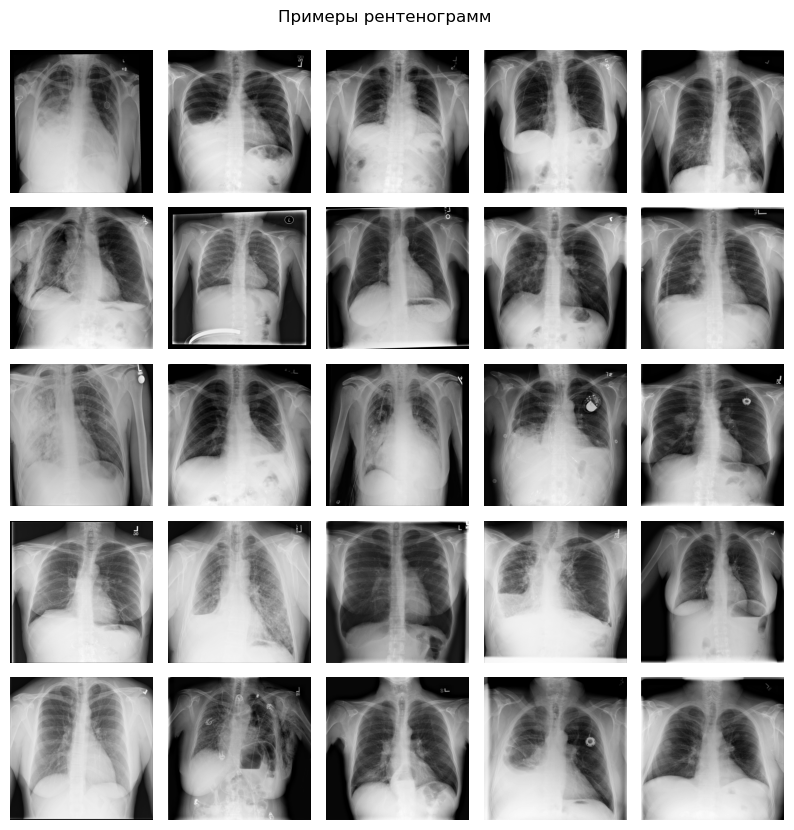

In [12]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
images = [Image.open(fp) for fp in list(data_dir.joinpath('Origin').iterdir())[:25]]
for img, ax in zip(images, axs.flat):
    ax.imshow(img, cmap=plt.cm.gray)
    ax.axis('off')
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.suptitle('Примеры рентенограмм', y=0.92);

#### Пример разметки

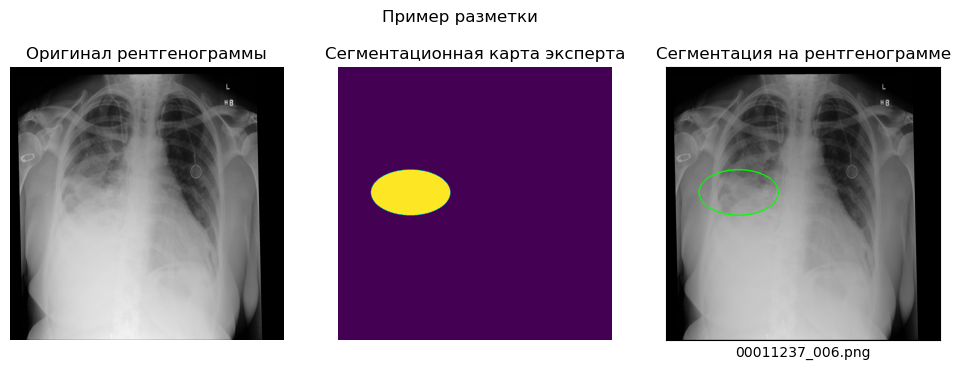

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

row = segmentation_df.loc[100]

axs[0].imshow(Image.open(row['origin_fp']), cmap=plt.cm.gray)
axs[0].axis('off')
axs[0].set_title('Оригинал рентгенограммы')
axs[1].imshow(Image.open(row['expert_mask_fp']))
axs[1].axis('off')
axs[1].set_title('Сегментационная карта эксперта')
plot_image_segmentation(row, metrics=False, sample_id=False, legend=False, ax=axs[2])
axs[2].set_title('Сегментация на рентгенограмме')
fig.suptitle('Пример разметки');

### Качество данных

Проведем анализ качества данных. Мы имеем в общем случае 100 рентгенограмм.

In [14]:
len(list(data_dir.joinpath('Origin').glob('*.png')))

100

#### Дубликаты

В датасете могут быть дубликаты рентгенограмм. Проверим их наличие с помощью перцептивного хеша горизонтальных градиентов интенсивности.

Возьмем порог схожести равный **7** и увидим, что есть две похожие картинки:

In [15]:
# Декларация функции в разделе "Полезные функции"
duplicates = check_duplicates(treshold=7)
duplicates

[(PosixPath('Dataset/Origin/00002706_004.png'),
  PosixPath('Dataset/Origin/00008547_001.png'))]

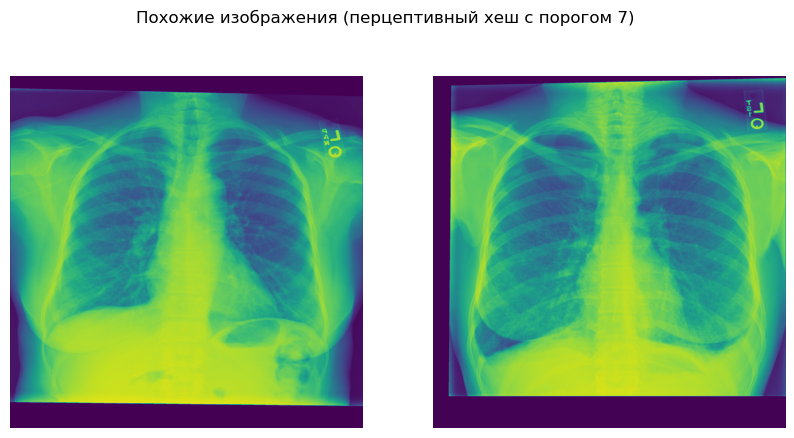

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(Image.open(duplicates[0][0]))
axs[1].imshow(Image.open(duplicates[0][1]))
axs[0].axis('off')
axs[1].axis('off')
fig.suptitle('Похожие изображения (перцептивный хеш с порогом 7)');

Картинки похожи, но явно различны. Делаем вывод, что дубликатов в датасете нет. Такой высокий порог обуславливается тем, что картинки с легкими все, в принципе, очень похожи.

#### Пропуски разметки

Все картинки были размечены экспертом и моделями. При проведении проверки на полноту разметок пропусков не обнаруживаем:

In [17]:
check_all_images_have_markup()

#### Баланс классов

В датасете присутствуют изображения, на которых эксперт не выделил патологий. Их немного, но об этом стоит знать.

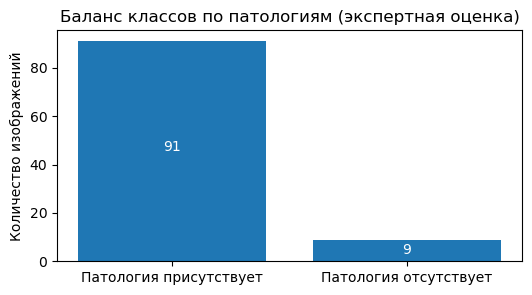

In [18]:
pathology_count = test_res_df[test_res_df['user_name'] == 'Expert']['file_name'].value_counts().shape[0]
healthy_count = test_res_df['file_name'].value_counts().shape[0] - pathology_count

fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(x=['Патология присутствует', 'Патология отсутствует'], 
       height=[pathology_count, healthy_count])
ax.text(0, pathology_count / 2, pathology_count, ha='center', color='white')
ax.text(1, healthy_count / 2, healthy_count, ha='center', va='center', color='white')
ax.set_ylabel('Количество изображений')
ax.set_title('Баланс классов по патологиям (экспертная оценка)');

#### Скрытые данные

Как уже было сказано ранее, работа моделей оценивалась экспертом. 

В данном датасете часть оценок скрыта, а именно оценки для 40 изображений из 100

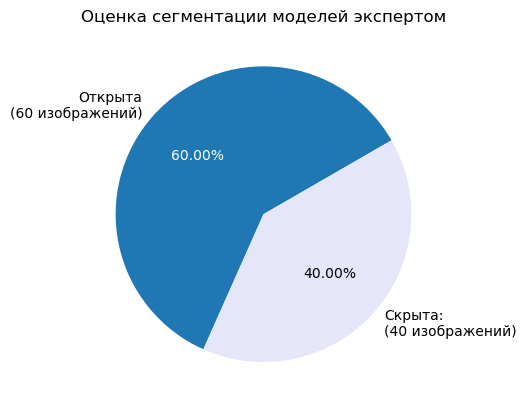

In [19]:
open_data = len(open_part_df)
hidden_data = test_res_df['file_name'].value_counts().shape[0] - open_data

labels = [f'Открыта\n({open_data} изображений)', 
            f'Скрыта:\n({hidden_data} изображений)']
_, _, autotexts = plt.pie([open_data, hidden_data], 
                          colors=['C0', "lavender"], autopct='%.2f%%', startangle=30, labels=labels)
autotexts[0].set_color('white')
plt.title('Оценка сегментации моделей экспертом');

### Наблюдения

#### Ошибка CSV файла находок

Как уже ранее упоминалось, при чтении датасета находок возникали ошибки, связанные с разным форматом строк csv файла. Всего было выявлено 3 формата строк:

1. Разделитель: ',', на конце строки: ','
1. Разделитель: ', ', на конце строки: ','
1. Разделитель: ', ', на конце строки: ', '

Так как каждая строка отвечает за обнаружение на какой либо картинке, было обнаружено странное совпадение (а может быть и не странное, а повлеченное определенным порядком создания датасета):

Изображения, описанные строками второго типа, но не описанные строками первого типа в какой либо из разметок ибеют пропуски.

In [20]:
with open(data_dir.joinpath('DX_TEST_RESULT_FULL.csv')) as f:
    df = f.read().split('\n')[1:-1]

In [21]:
# Не имеют пробелов между запятыми
r1 = {row.split(',')[0] for row in df if ', ' not in row}

# имеют пробелы между запятыми, но на конце не имеют пробела
r2 = {row.split(',')[0] for row in df if (', ' in row) and (row[-1] != ' ')}

# имеют пробелы между запятыми, и на конце имеют пробел
r3 = {row.split(',')[0] for row in df if (', ' in row) and (row[-1] == ' ')}

r2.difference(r1)

{'00000974_002',
 '00001187_006',
 '00002597_000',
 '00002706_004',
 '00005215_000',
 '00006323_009',
 '00007558_006',
 '00010060_038',
 '00012414_000',
 '00016589_005'}

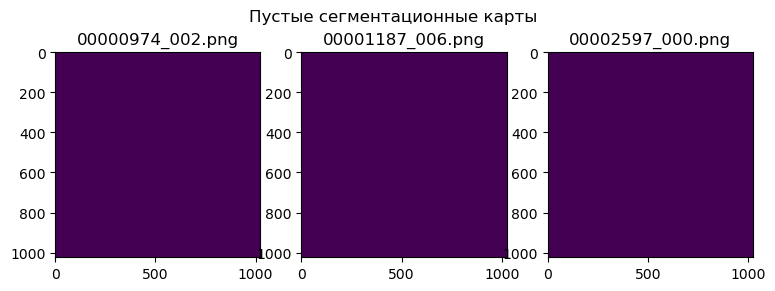

In [22]:
img_1 = Image.open(get_mask_fp('00000974_002.png', sub_dir='sample_1', postfix='_s1'))
img_2 = Image.open(get_mask_fp('00001187_006.png', sub_dir='sample_3', postfix='_s3'))
img_3 = Image.open(get_mask_fp('00002597_000.png', sub_dir='sample_3', postfix='_s3'))

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(img_1)
axs[0].set_title('00000974_002.png')
axs[1].imshow(img_2)
axs[1].set_title('00001187_006.png')
axs[2].imshow(img_3)
axs[2].set_title('00002597_000.png')


fig.suptitle('Пустые сегментационные карты');

Как использовать данную информацию не представляю, но по крайней мере были выделены ошибки в csv файле, которые нужно учитывать при его открытии.

### Оценки

По предложенным сегментационным картам были посчитаны следующие попиксельные метрики:

$$dice = \frac{2*tp}{2*tp + fp + fn}$$ 



$$precision = \frac{tp}{tp + fp}$$ 

$$jaccard = \frac{tp}{tp + fp + fn}$$

**skeletone_dist**, (oб этой метрике было сказано на треке "Ужасы медицинских данных" ([видео с привязкой ко времени](https://youtu.be/-1haCzvDKqg?list=LL&t=626))

Также, у нас есть оценка экспертом **expert_score**

#### Корреляции оценок

Посмотрим на корреляции метрик сегментаций. Видно, что довольно неплохо с оценкой эксперта коррелирует **jaccard** и **skeletone distance**. Возможно, в рамках данной задачи эти метрики наиболее состоятельны.

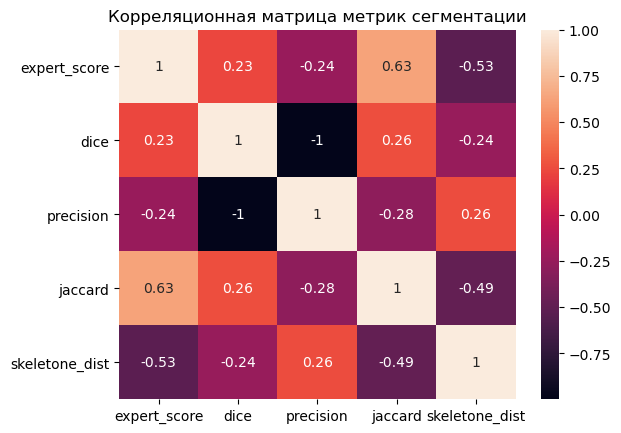

In [23]:
metrics_cor = segmentation_df[['expert_score', 'dice', 'precision', 'jaccard', 'skeletone_dist']].corr()
plot = sns.heatmap(metrics_cor, annot=True)
plot.set_title('Корреляционная матрица метрик сегментации');

#### Конфликт оценок



Можно заметить, что иногда метрика имеет довольно низкое значение, однако эксперт оценивает сегментацию модели на отлично. Например на графике **expert_score/jaccard** видно точку, в которой *jaccard* < 1, а *expert_score* = 5.

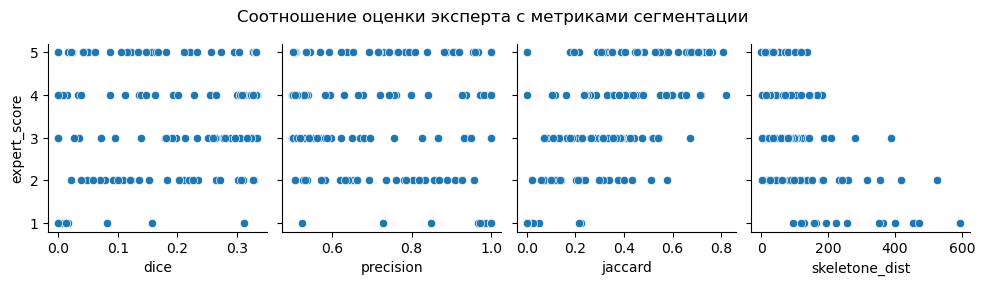

In [24]:
plot = sns.pairplot(segmentation_df, 
             x_vars=['dice', 'precision', 'jaccard', 'skeletone_dist'], 
             y_vars=['expert_score']);
plot.fig.suptitle('Соотношение оценки эксперта c метриками сегментации', y=1.1);

Посмотрим на эту картинку. Видно, что модель отметила участок с патологией. Возможно не очень точно.

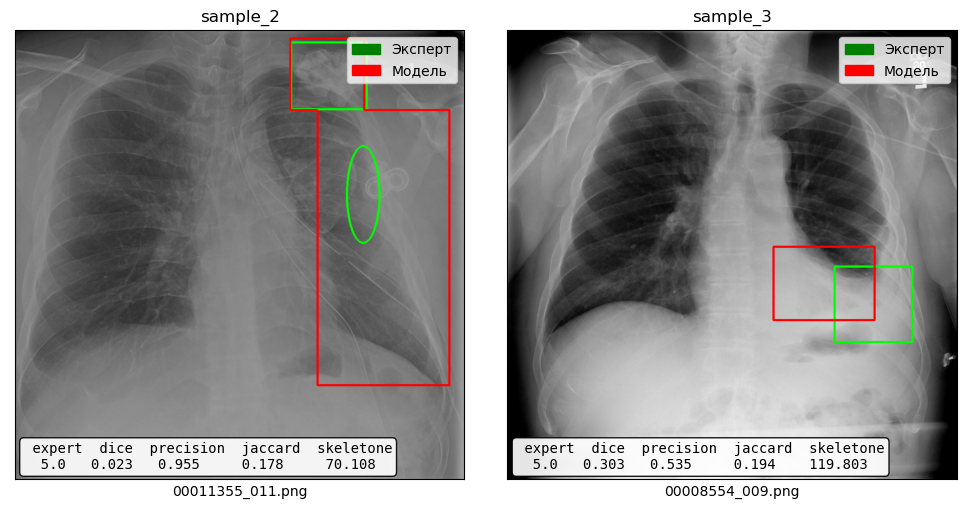

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

rows = segmentation_df[(segmentation_df['expert_score'] == 5) & (segmentation_df['jaccard'] < 0.2) & (segmentation_df['jaccard'] > 0)]
plot_image_segmentation(rows.iloc[0], image_name=True, ax=axs[0])
plot_image_segmentation(rows.iloc[1], image_name=True, ax=axs[1])
fig.tight_layout()

Возможно, эксперт высоко оценивал модели, локализующие все участки патологий, хоть и неточно. Посмотрим на другую ситуацию, когда оценка эксперта низкая, а jaccard высокий. 

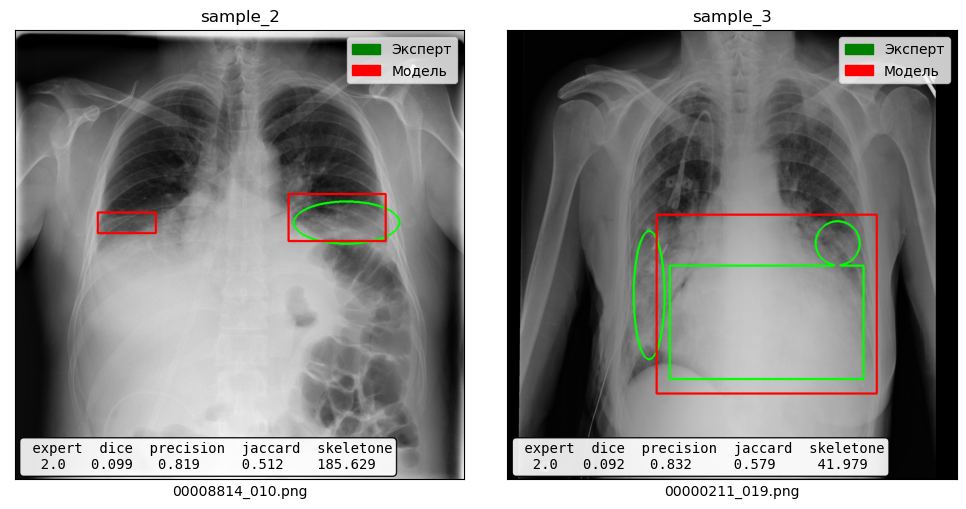

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

rows = segmentation_df[(segmentation_df['expert_score'] == 2) & (segmentation_df['jaccard'] > 0.5) & (segmentation_df['jaccard'] > 0)]
plot_image_segmentation(rows.iloc[0], image_name=True, ax=axs[0])
plot_image_segmentation(rows.iloc[1], image_name=True, ax=axs[1])
fig.tight_layout()

На картинке слева видно выделение лишней области, а справа три выделения ground trueth модель поместила в одно.

#### Бессилие моделей

Посмотрим на изображения, на которых сегментация патологий у моделей получилась хуже всего, по мнению эксперта

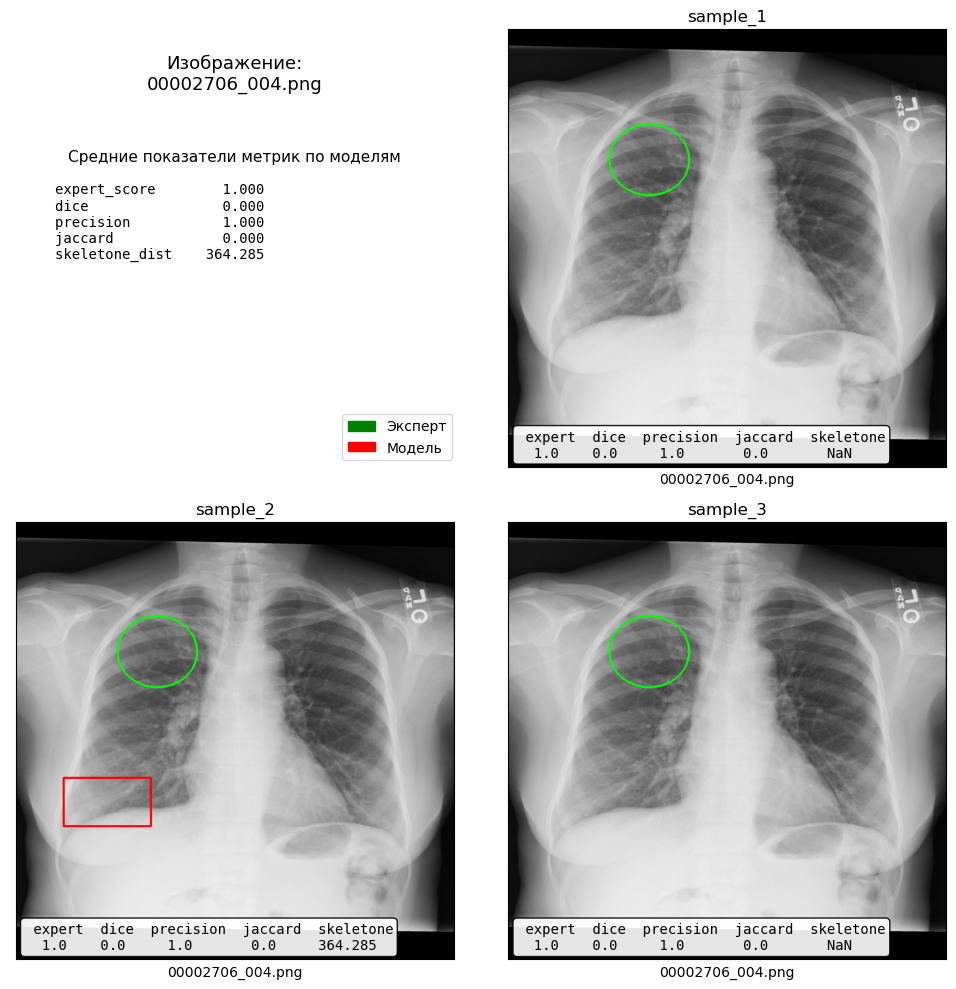

In [27]:
low_score_orig = segmentation_df.groupby('origin_fp')['expert_score'].mean().sort_values().index[0]
data = segmentation_df[segmentation_df['origin_fp'] == low_score_orig]
plot_segmentations(data)

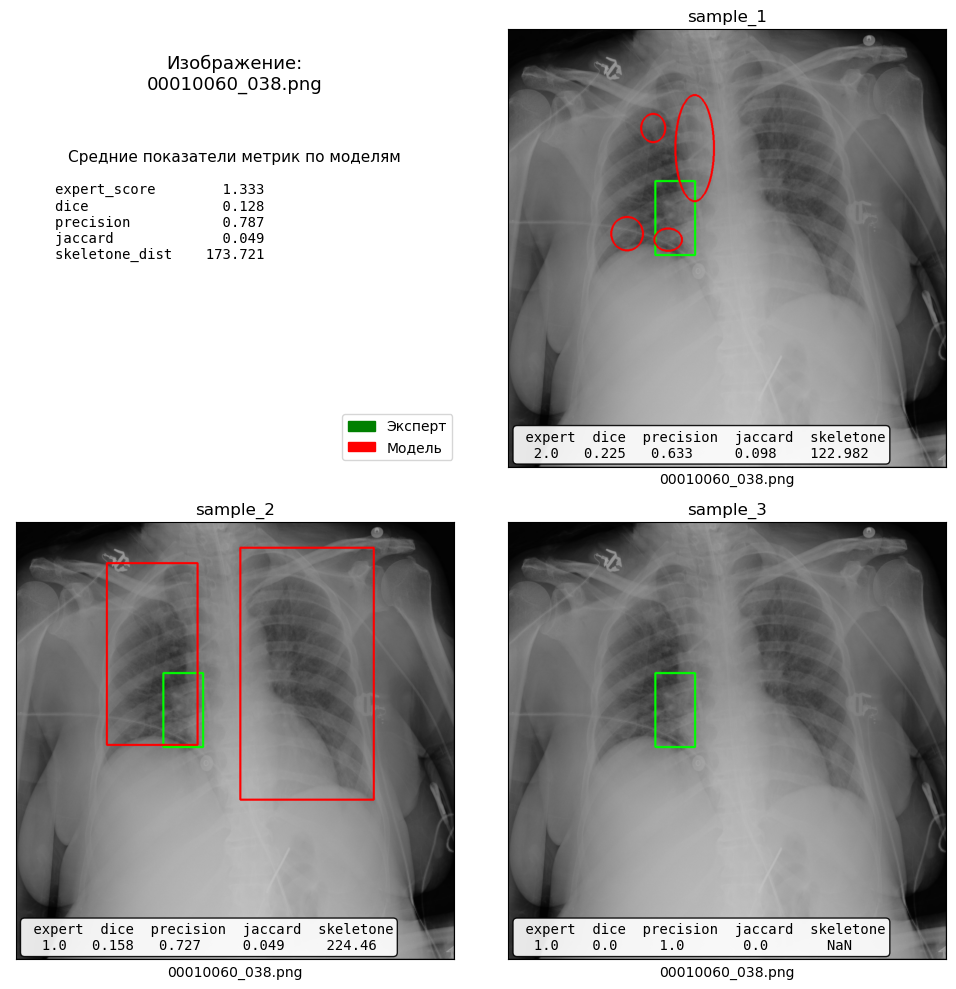

In [28]:
low_score_orig = segmentation_df.groupby('origin_fp')['expert_score'].mean().sort_values().index[1]
data = segmentation_df[segmentation_df['origin_fp'] == low_score_orig]
plot_segmentations(data)

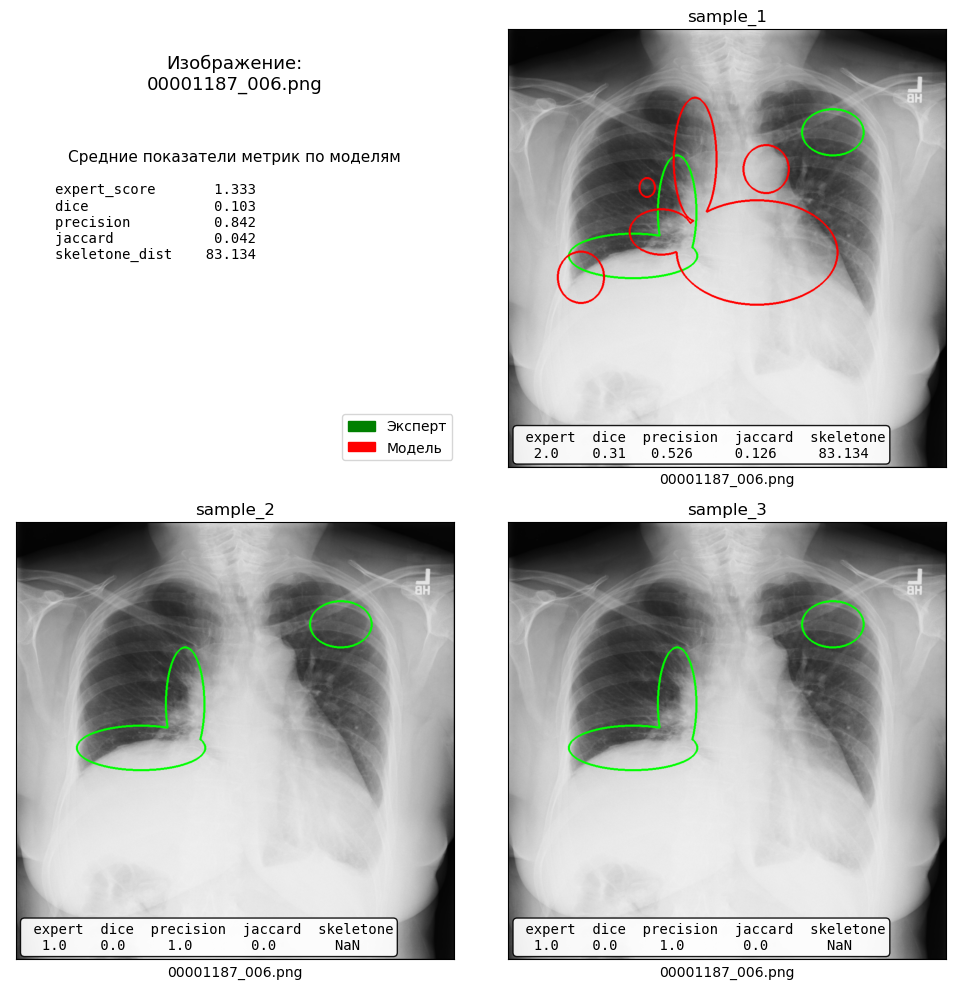

In [29]:
low_score_orig = segmentation_df.groupby('origin_fp')['expert_score'].mean().sort_values().index[2]
data = segmentation_df[segmentation_df['origin_fp'] == low_score_orig]
plot_segmentations(data)

Здесь сложно делать выводы. Нужно объяснение человека, разбирающегося в данных патологиях.

### Предсказание оценки эксперта

Попробуем предсказать оценку эксперта по метрикам сегментации. Использовать будем линейную регрессию для интерпретируемости важности метрик (коэффициентов).

In [30]:
lr = LinearRegression()
X = segmentation_df.dropna()[['precision', 'jaccard', 'skeletone_dist', 'dice']]
y = segmentation_df.dropna()['expert_score']

cross_val_score(lr, X, y, scoring='neg_mean_absolute_error').mean()

-0.7264770928810028

Получили неплохую среднюю абсолютную ошибку, равную **0.72**. Посмотрим на коэффициенты при переменных и оценим важность метрик. Оказывается, в большей степени на оценку эксперта влияет dice.

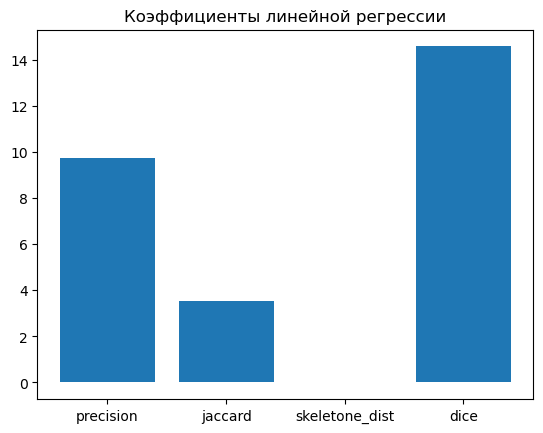

In [31]:
lr.fit(X, y)
plt.bar(X.columns, height=lr.coef_)
plt.title('Коэффициенты линейной регрессии');

## Выводы

В ходе расследовательского анализа данных мы изучили предоставили датасет, сделали выводы о его качестве, выдвинули несколько гипотез, посмотрели на каких рентгенограммах модель ошибается больше всего.

**Резюме**

* В датасете присутствуют 100 изображений. 
* Для каждого изображения есть сегментационные карты, сделанные экспертом и тремя моделями. 
* Дубликатов не обнаружено. 
* Для 60 изображений есть экспертная оценка сегментаций моделей по пятибальной шкале. 
* В 9 рентгенограммах из 100, по мнению эксперта, отсутствует патология.
* Обнаружены ошибки создания CSV файла в таблице находок.
* Лучше всего с оценкой эксперта кореллируют метрики *jacard* и *skeleton distance*
* Эксперт высоко оценивает модели, обнаружившие и локализовавшие патологию, даже если локализация неточная
* Эксперт низко оценивает модели, не обнаружившие или не локализовавшие патологию
* Оценку эксперта можно предсказать по метрикам сегментации, при этом средняя абсолютная ошибка предсказания: 0.72